# Machine Learning
After wrangling, EDA, and statistical analysis, I made a few decisions on how to set up and pursue predictions for dog adoptions.

* First, the algorithms I will use here are Random Forests and AdaBoost (Decision Tree Classifier base estimator).
    * I chose these algorithms because they are ensemble methods based on decision trees.  The ensemble part allows for many trees to be evaluated and many predictions made.  The average of these predictions is the output of the classifier.  There is power in numbers and wisdom in crowds so to speak.  By generating many trees and taking the average of their outputs, we hope to increase the generalization of the forest to new data by averaging out the noise.  One tree by itself is prone to large variance and overfitting.
    * Decision Trees and Random Forests are suited to this dataset in the following ways:
        * It runs efficiently on large datasets.
        * It can handle large amounts of features.
        * It gives some insight into what features are important in the classification.
        * It can handle features of mixed type well (continuous, categorical, etc).  There is no need to normalize or standardize the data.
        * It handles missing values well.
        * It has an innate robustness against outliers in the features.
        
    * AdaBoost with Decision Trees as the base classifier are suited to this dataset in similar ways, but also has these differences:
        * The weak learners evolve over time.  This is done by weighting the mislabeled points on each iteration of the algorithm.
        * Might have a better chance with the data in this example.
        

* Second, I decided to make predictions on two topics:
    * What outcome_type will the dog be?
    * How long will the dog spend in the shelter?
    
    
* Third, the categories for each prediction are outlined below.
    * For the outcome_type prediction, the categories will be the 3 wrangled outcome groups in the statistical analysis section (Adoptions, Transfers, Deaths)
    * The time to adoption categories will be as defined as they were in the EDA section based from the distribution of time to adoption values.
        * The first being adopted in 7 days (1 week) or less.
        * The second being 8 - 21 days (3 weeks).
        * The third being 22 - 50 days (7 weeks).
        * The last being 50+ days (outliers).
    * I chose to do groups intstead of linear regression techniques because I have strong suspicions that the model will always perform poorly if trying to predict the exact time to adoption.  Groups will allow for classification, which I believe the model will have more success performing. The impact is still similar in that we can still obtain quality information about the estimated time to adoption.  Also, the time groups are picked in such a manner as to try and avoid selection bias or being heavily weighted with samples in one or two groups, while still being meaningful and useful prediction categories.


* Fourth, the performance scoring criterion for both predictions will be the classification report which includes precision, recall, and f1 scores for each class and an average for the scores. Emphasis will be put on the f1_score as this score is best indicative in this case for a better model as I don't want too many false positives, and I also don't want too many false negatives. 
    
* Fifth, to obtain a feel for what features are most important when it comes to dog adoptability, we will look at the importance of the features used in the models.

* Last, the models for outcome type and shelter time predictions will be trained separately on the same intake data.  However, the time to adoption will also be trained on the outcome_type data from the shelter data.
    * This is because the output of the outcome_type model will be input as a feature into the shelter time model for new data.

In [1]:
#load data and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

#import the dogs_join dataframe that has been wrangled and added to in the previous notebooks
dogs_join = pd.read_csv('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_join_stat.csv', encoding='latin-1')

C:\Users\sethh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
#get a look at the loaded dataframe
print(dogs_join.info())
print()
print('The shape of the dataframe is (rows, columns): {}'.format(dogs_join.shape))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49564 entries, 0 to 49563
Data columns (total 27 columns):
animal_id           49564 non-null object
datetime_in         49564 non-null object
intake_condition    49564 non-null object
intake_type         49564 non-null object
name_in             49564 non-null object
color1              49564 non-null object
color2              49564 non-null object
intake_age          49564 non-null float64
found_loc           49564 non-null object
intake_sex          49564 non-null object
intake_fixed        49564 non-null object
breed1              49564 non-null object
breed2              49564 non-null object
intake              49564 non-null int64
datetime_out        49111 non-null object
name_out            49110 non-null object
outcome_subtype     49111 non-null object
outcome_type        49111 non-null object
outtake_age         49111 non-null object
outtake_sex         49111 non-null object
outtake_fixed       49111 non-null object
outtake  

### Wrangling for Machine Learning
In order to use the data in the dataframe created in the earlier steps in machine learning algorithms, we still need to do a bit more wrangling.
* The non numeric data needs to be converted to numeric values.
* The outtake features are not needed besides the shelter_time and outcome_type columns.
    * The outtake data is not needed because for new incoming pets or pets still in the shelter, there will not be any outtake data.
* The data with all null outtake entries are dogs still in the shelter and will be set aside for predictions after the best tuned algorithm emerges.
* We need to take a look at the one remaining null entry in the name_in column.

In [3]:
#Let's start by looking at the one null entry in the name_in column
dogs_join.loc[dogs_join.name_in.isnull()]

,animal_id,datetime_in,intake_condition,intake_type,name_in,color1,color2,intake_age,found_loc,intake_sex,...,outcome_type,outtake_age,outtake_sex,outtake_fixed,outtake,shelter_time,intake_age_cat,intake_season,population,AKC_group


In [4]:
#let's name the dogs without name 'No Name'
dogs_join.name_in = dogs_join.name_in.fillna('No Name')

In [5]:
#let's save dogs_join and continue wrangling under the name dogs_ML
dogs_join.to_csv('C:/Users/sethh/OneDrive/Desktop/Springboard/Capstone Project 2/dogs_join_stat.csv', index=False)
dogs_ML = dogs_join
dogs_ML.reset_index(drop=True)

#let's store the animal ids as their own series and drop from the dataframe as they are unique to each individual animal
#and shouldn't have an influence on the adoption outcomes.
dogs_ids = dogs_ML.animal_id
dogs_ML = dogs_ML.drop('animal_id', axis=1)

In [6]:
#now let's get rid of the unnecessary outtake data columns from dogs_ML
dogs_ML = dogs_ML.drop(axis=1, labels=['datetime_out','name_out', 'outcome_subtype', 'outtake_age', 'outtake_sex', 'outtake_fixed',
                               'outtake'])

#remove from dogs_ML and set aside the outtake entries that are null as "dogs_shelter"
dogs_shelter = dogs_ML.loc[dogs_ML.shelter_time.isnull()]
dogs_ML = dogs_ML.dropna()

### Now it is time to do some Feature Engineering.
Start off by creating the data and labels dataframes.
* First, drop the labels from the dogs_ML dataframe and store as data.
* Second, store the outcome_type and shelter_time columns from dogs_ML as labels.


Now for the feature engineering.
* The datetime column is too specific.
    * I will encode the datetime column as only containing the month information because the exact timestamp is too specific and would generate a lot of extra features upon one hot encoding.
* The name_in column is too specific and has too many unique entries.  
    * To try and extract useful information about this feature, I will use the value_counts for each name as the data.
    * Hopefully, this will feed name popularity information into the machine learning algorithms.
* As seen previously in the EDA, the intake_condition is virtually all normal minus outlying cases.
    * I will turn the intake_condtion into a binary column: 1 for not normal and 0 for normal to distinguish the rare cases.
* The primary color (color1) and the secondary color (color2) data will be encoded as popularity information similar to the name_in column.
* For found_loc, over 40,000 are in Austin.
    * I will turn the found_loc into a binary column: 1 for not Austin and 0 for Austin.
* The primary breed (breed1) and the secondary breed (breed2) data will be encoded as popularity information similar to the name_in column.
* The intake age category will be stored numerically in the following manner:
    * Puppy: 0
    * Young Adult: 1
    * Adult: 2
    * Senior: 3
* The seasons will be encoded into one feature intake_season with:
    * 0 for Summer
    * 1 for Fall
    * 2 for Winter
    * 3 for Spring
* Intake_sex will be regrouped into one feature with 0 for Male, 1 for Female and Unknown.
* Intake_fixed will be regrouped into one binary feature with 0 for Spayed/Neutered and 1 for Intact/Unknown.
* Intake_type will be regrouped into one binary feature with 0 for Stray and 1 for all other types.
    * Stray is the vast majority.
* Population will be incoded as binary with top5 as 0 and 1 for bottom.
* AKC_group will be denoted 0-7 to distinguish the breed groups.
    * 0 for Sporting
    * 1 for Hound
    * 2 for Herding
    * 3 for Terrier
    * 4 for Non-Sporting
    * 5 for Toy
    * 6 for Working
    * 7 for Misc
* Also, outcome_type will be wrangled for the shelter_time predictions as discussed above.
    * 0 for Adoption
    * 1 for Transfer
    * 2 for Death

In [7]:
#set up a function to extract the value_counts as features for a series
def feature_pop(series):
    """
    Takes a series and returns a list with the unique value counts for each entry in the series.
    """
    #store the value_counts in a dictionary.
    counts = {index: value for index, value in series.value_counts().iteritems()}
    series_counts = [counts[item] for item in series]
    return series_counts

In [8]:
#let's now define a function for turning a multi category feature into a binary category feature
def multi_to_binary(series, major_cat):
    """
    Takes a series with more than two categories and returns a list with only two categories encoded.
    1 for the rarer category and 0 for the more popular category.
    """
    binary = [(1 if cat not in major_cat else 0) for cat in series]
    return binary

In [9]:
#create a feature engineering function
def feat_eng(df):
    """
    Takes a dataframe df and returns a df and a features matrix that has gone through the feature engineering process.
    """
    
    #parse the datetime column and pull only the month from the date.  Also, drop the datetime_in column
    df.datetime_in = pd.to_datetime(df.datetime_in)
    df['intake_month'] = [date.month for date in df.datetime_in]
    df = df.drop('datetime_in', axis=1)
    
    #encode the intake_age_cat numerically
    for index, row in df.iterrows():
        if row.intake_age_cat == 'Puppy':
            df.loc[index, 'intake_age_cat'] = 0
        elif row.intake_age_cat == 'Young Adult':
            df.loc[index, 'intake_age_cat'] = 1
        elif row.intake_age_cat == 'Adult':
            df.loc[index, 'intake_age_cat'] = 2
        else:
            df.loc[index, 'intake_age_cat'] = 3
    df.intake_age_cat = df.intake_age_cat.astype(int)
    
    #encode the intake_season numerically
    for index, row in df.iterrows():
        if row.intake_season == 'Summer':
            df.loc[index, 'intake_season'] = 0
        elif row.intake_season == 'Fall':
            df.loc[index, 'intake_season'] = 1
        elif row.intake_season == 'Winter':
            df.loc[index, 'intake_season'] = 2
        else:
            df.loc[index, 'intake_season'] = 3
    df.intake_season = df.intake_season.astype(int)
    
    #encode the AKC_group numerically
    for index, row in df.iterrows():
        if row['AKC_group'] == 'Sporting':
            df.loc[index, 'AKC_group'] = 0
        elif row['AKC_group'] == 'Hound':
            df.loc[index, 'AKC_group'] = 1
        elif row['AKC_group'] == 'Herding':
            df.loc[index, 'AKC_group'] = 2
        elif row['AKC_group'] == 'Terrier':
            df.loc[index, 'AKC_group'] = 3
        elif row['AKC_group'] == 'Non-Sporting':
            df.loc[index, 'AKC_group'] = 4
        elif row['AKC_group'] == 'Toy':
            df.loc[index, 'AKC_group'] = 5
        elif row['AKC_group'] == 'Working':
            df.loc[index, 'AKC_group'] = 6
        else:
            df.loc[index, 'AKC_group'] = 7
    df.AKC_group = df.AKC_group.astype(int)
    
    #now calculate the popularity info for the features that will be expressed as such (name_in, color1, color2, breed1, 
    #and breed2)
    df.name_in = feature_pop(series=df.name_in)
    df.color1 = feature_pop(series=df.color1)
    df.color2 = feature_pop(series=df.color2)
    df.breed1 = feature_pop(series=df.breed1)
    df.breed2 = feature_pop(series=df.breed2)
    
    #now calculate the binary features for found_loc, intake_condition, intake_sex, intake_fixed, population
    df.intake_condition = multi_to_binary(df.intake_condition, 'Normal')
    df.found_loc = multi_to_binary(df.found_loc, 'Austin')
    df.intake_sex = multi_to_binary(df.intake_sex, 'Male')
    df.intake_fixed = multi_to_binary(df.intake_fixed, ['Spayed', 'Neutered'])
    df.intake_type = multi_to_binary(df.intake_type, 'Stray')
    df.population = multi_to_binary(df.population, 'top5')
    
    #try to wrangle the outcome_type feature numerically
    try:
        for index, row in df.iterrows():
            if row['outcome_type'] == 'Adoption':
                df.loc[index, 'outcome_type'] = 0
            elif row['outcome_type'] == 'Transfer':
                df.loc[index, 'outcome_type'] = 1
            else:
                df.loc[index, 'outcome_type'] = 2
        df.outcome_type = df.outcome_type.astype(int)
    except:
        print('df missing outcome_type column')
                
    
    #convert data into an numpy 2-D array
    X = df.as_matrix()
    
    return df, X

In [10]:
#now let's create the data sets and the labels
data_outcome_type = dogs_ML.drop(['outcome_type','shelter_time'], axis=1)
data_shelter_time = dogs_ML.drop(['shelter_time'], axis=1)
dogs_shelter = dogs_shelter.drop(['outcome_type', 'shelter_time'], axis=1)
labels = dogs_ML.loc[:, ['outcome_type','shelter_time']]

#run feature engineering on the data sets
data_outcome_type, X_outcome = feat_eng(data_outcome_type)
data_shelter_time, X_time = feat_eng(data_shelter_time)
dogs_shelter, X_new = feat_eng(dogs_shelter)

df missing outcome_type column
df missing outcome_type column


In [11]:
print(data_outcome_type.shape)
print(data_shelter_time.shape)
print(dogs_shelter.shape)
data_outcome_type.info()

(49111, 17)
(49111, 18)
(453, 17)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49111 entries, 0 to 49553
Data columns (total 17 columns):
intake_condition    49111 non-null int64
intake_type         49111 non-null int64
name_in             49111 non-null int64
color1              49111 non-null int64
color2              49111 non-null int64
intake_age          49111 non-null float64
found_loc           49111 non-null int64
intake_sex          49111 non-null int64
intake_fixed        49111 non-null int64
breed1              49111 non-null int64
breed2              49111 non-null int64
intake              49111 non-null int64
intake_age_cat      49111 non-null int32
intake_season       49111 non-null int32
population          49111 non-null int64
AKC_group           49111 non-null int32
intake_month        49111 non-null int64
dtypes: float64(1), int32(3), int64(13)
memory usage: 7.4 MB


* Now we can get the labels in order.
    * For outcome_type, 0 will be for Adoption, 1 will be for Transfer, and 2 will be for Death.
        * The categories are defined and made in the statistical analysis section.
    * For the time to adoption, the labels will be created by labeling each instance with the correct time grouping defined previously and below.
        * 0 will be adopted in 7 days or less.
        * 1 will be adopted in 8-21 days.
        * 2 will be adopted in 22-50 days.
        * 3 will be adopted in 51+ days.

In [12]:
#prepare the outcome_type labels
for index, row in labels.iterrows():
    if row['outcome_type'] == 'Adoption':
        labels.loc[index, 'outcome_type'] = 0
    elif row['outcome_type'] == 'Transfer':
        labels.loc[index, 'outcome_type'] = 1
    else:
        labels.loc[index, 'outcome_type'] = 2

y_outcome = np.array(labels.outcome_type.astype(int))

#prepare the shelter_time labels
for index, row in labels.iterrows():
    if row['shelter_time'] <= 7:
        labels.loc[index,'shelter_time'] = 0
    elif (row['shelter_time']>=8) & (row['shelter_time']<=21):
        labels.loc[index,'shelter_time'] = 1
    elif (row['shelter_time']>=22) & (row['shelter_time']<=50):
        labels.loc[index,'shelter_time'] = 2
    else:
        labels.loc[index,'shelter_time'] = 3
        
y_time = np.array(labels.shelter_time.astype(int))

#check y_time and y_adopted
print(pd.Series(y_time).value_counts())
print(pd.Series(y_outcome).value_counts())
print(len(y_time))
print(len(y_outcome))

0    31447
1    10139
2     4083
3     3442
dtype: int64
0    36851
1    10550
2     1710
dtype: int64
49111
49111


* The data labels are grouped in ways to the best represent the data in meaningful ways to the pet shelter.  The data in the shelter seems biased.  However, this is the data reported by the shelter.  I have not introduced my own selection bias.  Hopefully the random nature of the ensemble algorithms will help to fight the selection bias a bit and represent good predictions for both.
    * Side Note: Brief testing showed that stratified sampling actually decreased the performance of all models.
* Now that the data and labels are prepared, we can get into the algorithms.


* We will start with Default Random Forests.
* Also, we will keep track of the feature importances and the f1_score for each algorithm and run.
    * This will be kept in a data frame.

In [13]:
#import all the necessary functions from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

#make a function to run the algorithm and generate performance ratings
def rand_search_cv(prediction, model_name, pipeline, X, target, params, class_labels, split_test_size=.3, rand_iters=10, cv_folds=3):
    """Takes a pipeline, data, targets, CV search params, test_size, 
    number of iters and number of folds for RandomizedSearchCV, and the labels of classes.
    
    Returns a tuned and fitted model and f1 weighted score and prints a classification report and f1 score."""
    
    #split data into train and test sets with stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = split_test_size, random_state=42)
    
    if params:
        #run grid search on pipeline
        gm_cv = RandomizedSearchCV(pipeline, param_distributions = params, 
                               cv=cv_folds, n_iter=rand_iters, random_state=42, n_jobs=3)
        gm_cv.fit(X_train, y_train)
        best_params = gm_cv.best_params_
        importances = gm_cv.best_estimator_.named_steps[model_name].feature_importances_
        print('The best param values are value is {}, with an accuracy of {}.'.format(gm_cv.best_params_, gm_cv.best_score_))
        print()
        
        
    else:
        gm_cv = pipeline
        gm_cv.fit(X_train, y_train)
        best_params = 0
        importances = gm_cv.named_steps[model_name].feature_importances_
    
    
        
    #test model on test dataset and get classification report.
    y_pred = gm_cv.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=class_labels))
    print()
    
    #get f1 score for model comparison
    f1 = f1_score(y_test, y_pred, average='weighted')
    print('The f1 score is : {}'.format(f1))
    
    #check for the prediction type
    if prediction == 'outcome':
        features = data_outcome_type.columns.values
    else:
        features = data_shelter_time.columns.values
    #let's look at the feature importance and cumulative importances
    feat_imp = pd.DataFrame([[feature, round(importance, 2)] for feature, importance in zip(features, importances)], 
                            columns=['feature','importance'])
    feat_imp = feat_imp.set_index('feature', drop=True)
    sorted_feat_imp = feat_imp.sort_values('importance',ascending=False)
    cum_imp = np.cumsum(sorted_feat_imp.loc[:,'importance'])
    x_range = range(0, len(sorted_feat_imp))
    per_cum_hori = [0.95 for _ in x_range]

    plt.figure(figsize=(12,6))
    plt.bar(x_range, sorted_feat_imp.loc[:,'importance'], label='feature_importances')
    plt.plot(x_range, cum_imp, label='cumulative_feature_importances',color='gray')
    plt.plot(x_range, per_cum_hori, label='95% cumulative feature importance', color='red')

    plt.xlabel('features')
    plt.ylabel('importance')
    plt.title('Feature Importance for ' + model_name)
    plt.yticks(np.arange(0,1.5,.1))
    plt.xticks(x_range,sorted_feat_imp.index,rotation=90)
    plt.legend(loc='best')
    plt.show()
    
    return gm_cv, f1, sorted_feat_imp

***
* Pipelines will be built here for future incorporation of fancier feature unions, transforms, feature scaling, component analysis, etc if desired.

* Also, as this is being run on a laptop.  I kept the cv folds down to 3 and the for the RandomizedSearchCV part, the iterations will only be 100, with max number of estimators (trees) being capped at 5000 as well.  
    * More performance gains may be made on more powerful equipment were the iterations can be increased, etc.

### Default Random Forests for Adopted Predictions

             precision    recall  f1-score   support

   Adoption       0.80      0.95      0.87     11105
   Transfer       0.52      0.23      0.32      3100
      Death       0.44      0.16      0.23       529

avg / total       0.73      0.77      0.73     14734


The f1 score is : 0.7278184533873882


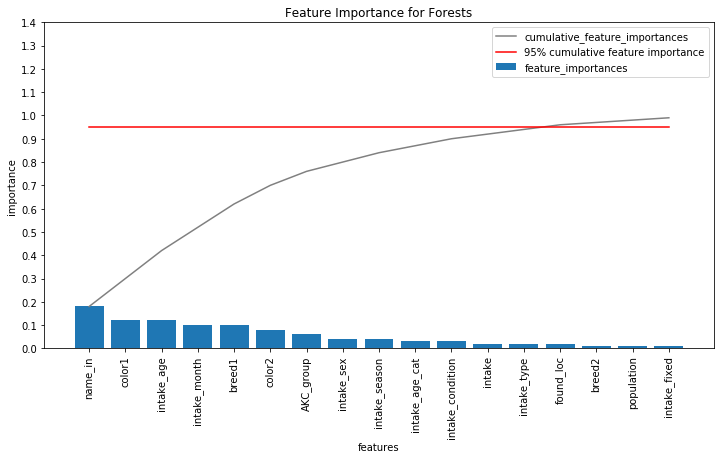

In [14]:
#set up the performance and importance dataframes
feat_imp_outcome = pd.DataFrame(index=data_outcome_type.columns.values)
f1_scores_outcome = pd.DataFrame(index=['f1'])

#for default tuned features we will just build a pipeline with the classifier and pass 0 to params
#set up pipeline
steps = [('Forests', RandomForestClassifier())]

pipeline_RF = Pipeline(steps)

#set up grid search cross validation parameters and other params needed to generate the classifier
params_RF = 0
adopted_labels=['Adoption', 'Transfer', 'Death']



#run the classifier
RF_outcome_default, f1_adopted, sorted_feat_imp = rand_search_cv(pipeline = pipeline_RF, X=X_outcome, 
                                                                 target=y_outcome, params=params_RF, class_labels=adopted_labels, 
                                                                 split_test_size=.3, cv_folds=3, model_name='Forests',
                                                                 prediction='outcome')

#store f1 and importance values in their respective dataframes
f1_scores_outcome.loc['f1','Default RF'] = f1_adopted

for index in feat_imp_outcome.index.values:
    feat_imp_outcome.loc[index,'Default RF'] = sorted_feat_imp.loc[index,'importance']

****

### Next we can try tuning the Random Forest Classifier.
* One of the biggest ways to generate better performance is to gather more data and/or optimize the features.  As shown in the plot above, no one feature is massively dominant in decision importance of the random forest trees.  However, 80% of the importance is represented by 6 features as shown above.  
* I am limited to the data freely supplied online by the animal shelter for this project.  Thus, gathering more data is not a viable option at this point.  Moreover, feature engineering was done in the EDA and statistical analysis to create metrics to test.  Those metrics have been carried over as data input into the machine learning algorithms.

### Tuning continued...
* That leaves hyper parameter tuning.


Hyper parameters to tune:
* The hyper parameters that have the most effect on the model performance are:
    * n_estimators: The number of trees in the forest.
    * max_features: The number of features considered for splitting at each leaf node.
    
    
* For time and simplicity, I will only tune a few more of the features: 
    * criterion : The function to measure the quality of a split.
    * min_samples_split: The minimum number of samples required to split an internal node.
    * min_samples_leaf: The minimum number of samples required to be at a leaf node.
    * bootstrap: Whether bootstrap samples are used when building trees.

The best param values are value is {'Forests__n_estimators': 1601, 'Forests__min_samples_split': 4, 'Forests__min_samples_leaf': 2, 'Forests__max_features': 'auto', 'Forests__criterion': 'gini', 'Forests__bootstrap': True}, with an accuracy of 0.7742385897547779.

             precision    recall  f1-score   support

   Adoption       0.80      0.98      0.88     11105
   Transfer       0.68      0.20      0.31      3100
      Death       0.61      0.17      0.26       529

avg / total       0.77      0.79      0.74     14734


The f1 score is : 0.7370558589184112


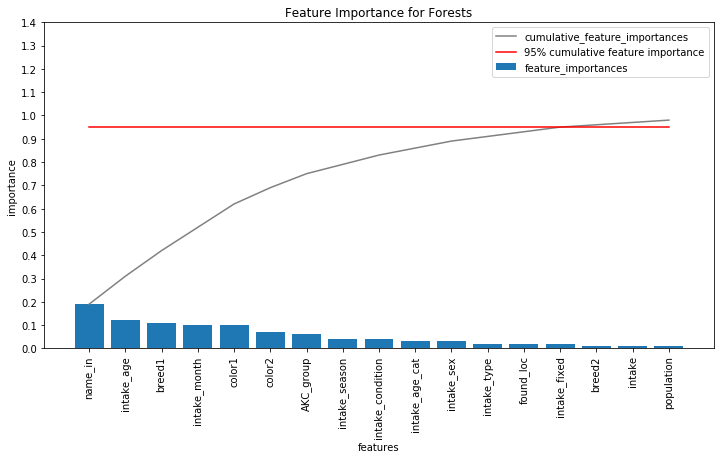

In [15]:
#for default we will just build a pipeline with the classifier and pass 0 to params
#set up pipeline
steps = [('Forests', RandomForestClassifier())]

pipeline_RF = Pipeline(steps)

#set up grid search cross validation parameters and other params needed to generate the classifier
params_RF = {"Forests__max_features": ['auto','log2'],
             "Forests__n_estimators": range(1, 5001, 100),
             "Forests__criterion": ['gini','entropy'],
             "Forests__min_samples_split": range(2,20),
             "Forests__min_samples_leaf": range(1,20),
             "Forests__bootstrap": [True, False]}

adopted_labels=['Adoption', 'Transfer', 'Death']




RF_outcome_tuned, f1_adopted, sorted_feat_imp = rand_search_cv(pipeline = pipeline_RF, X=X_outcome, 
                                                            target=y_outcome, params=params_RF, class_labels=adopted_labels, 
                                                            split_test_size=.3, rand_iters=100, cv_folds=3,
                                                            model_name='Forests', prediction='outcome')

#store f1 and importance values in their respective dataframes
f1_scores_outcome.loc['f1','Tuned Hyper Parameters RF'] = f1_adopted

for index in feat_imp_outcome.index.values:
    feat_imp_outcome.loc[index,'Tuned Hyper Parameters RF'] = sorted_feat_imp.loc[index,'importance']

***

## AdaBoost Adopted Predictions

* I will follow the same outline in running AdaBoost that I used for Random Forests.
* The reduced features data will be used as the Default base model so I can directly compare the performance between Random Forests and AdaBoost.
* I will also use the DecisionTreeClassifier as the base estimator.

### Default AdaBoost

             precision    recall  f1-score   support

   Adoption       0.78      0.98      0.87     11105
   Transfer       0.57      0.12      0.19      3100
      Death       0.50      0.15      0.23       529

avg / total       0.73      0.77      0.70     14734


The f1 score is : 0.7039424243317506


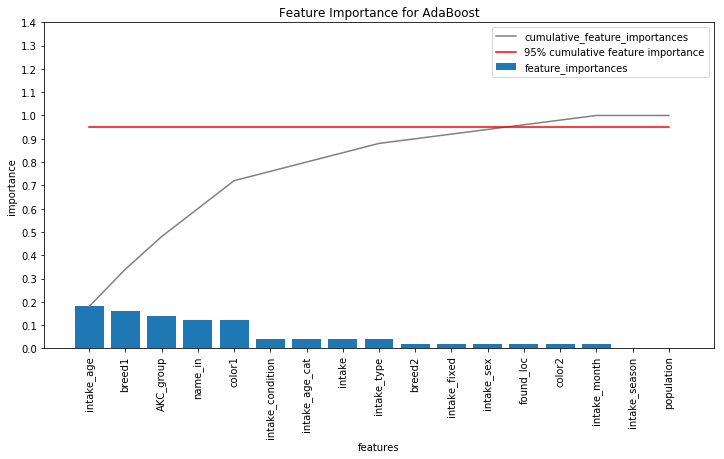

In [16]:
#import AdaBoost
from sklearn.ensemble import AdaBoostClassifier

#for default reduced features we will just build a pipeline with the classifier and pass 0 to params
#set up pipeline
steps = [('AdaBoost', AdaBoostClassifier())]

pipeline_Ada = Pipeline(steps)

#set up grid search cross validation parameters and other params needed to generate the classifier
params_Ada = 0
adopted_labels=['Adoption', 'Transfer', 'Death']



#run the classifier
Ada_outcome_default, f1_adopted, sorted_feat_imp = rand_search_cv(pipeline = pipeline_Ada, X=X_outcome, 
                                                                  target=y_outcome, params=params_Ada, class_labels=adopted_labels,
                                                                  split_test_size=.3, cv_folds=3, model_name='AdaBoost',
                                                                  prediction='outcome')

#store f1 and importance values in their respective dataframes
f1_scores_outcome.loc['f1','Default Ada'] = f1_adopted

for index in feat_imp_outcome.index.values:
    feat_imp_outcome.loc[index,'Default Ada'] = sorted_feat_imp.loc[index,'importance']

### Tuning Hyper Parameters...

* AdaBoost has the following tunable hyper parameters:
    * n_estimators : The maximum number of estimators at which boosting is terminated.
        * Set same as RF.
    * learning_rate : Learning rate shrinks the contribution of each classifier by learning_rate.
        * Set .1 to 10000 logarithmic scale.
    * algorithm : {‘SAMME’, ‘SAMME.R’}

The best param values are value is {'AdaBoost__n_estimators': 3401, 'AdaBoost__learning_rate': 1.4508287784959395, 'AdaBoost__algorithm': 'SAMME'}, with an accuracy of 0.7601594089071181.

             precision    recall  f1-score   support

   Adoption       0.78      0.98      0.87     11105
   Transfer       0.55      0.13      0.21      3100
      Death       0.48      0.15      0.23       529

avg / total       0.72      0.77      0.71     14734


The f1 score is : 0.7060929412429057


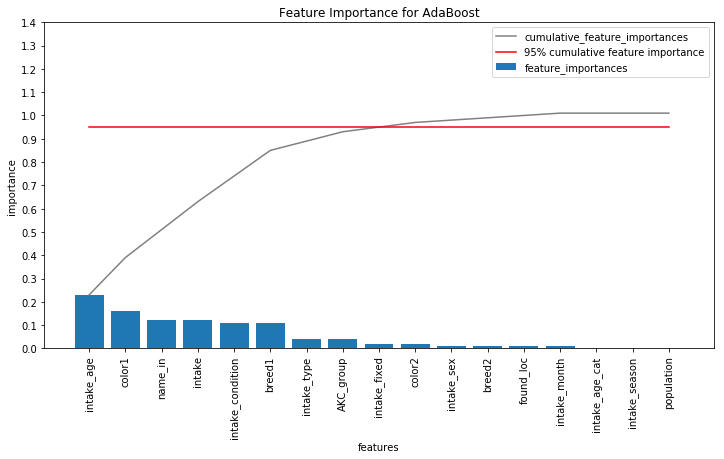

In [17]:
#set up pipeline
steps = [('AdaBoost', AdaBoostClassifier())]

pipeline_Ada = Pipeline(steps)

#set up grid search cross validation parameters and other params needed to generate the classifier
params_Ada = {'AdaBoost__n_estimators': range(1, 5001, 100),
              'AdaBoost__learning_rate': np.logspace(-1,4,100),
              'AdaBoost__algorithm':['SAMME','SAMME.R']}
adopted_labels=['Adoption', 'Transfer', 'Death']



#run the classifier
Ada_outcome_tuned, f1_adopted, sorted_feat_imp = rand_search_cv(pipeline = pipeline_Ada, X=X_outcome, 
                                                            target=y_outcome, params=params_Ada, class_labels=adopted_labels,
                                                            split_test_size=.3, cv_folds=3, model_name='AdaBoost', 
                                                            rand_iters=100, prediction='outcome')

#store f1 and importance values in their respective dataframes
f1_scores_outcome.loc['f1','Tuned Ada'] = f1_adopted

for index in feat_imp_outcome.index.values:
    feat_imp_outcome.loc[index,'Tuned Ada'] = sorted_feat_imp.loc[index,'importance']

***

## Now it is time to work with predicting the shelter time.

* I will use the same reduced feature data on the samples plus the outcome_type data as an extra feature.
* The data labels will be the y_time labels generated earlier.
* The same methodology used for the adopted predictions will be used here.

### Random Forest Default Model

                  precision    recall  f1-score   support

less than 7 days       0.70      0.89      0.78      9314
    8 to 21 days       0.36      0.21      0.27      3130
   22 to 50 days       0.35      0.14      0.20      1226
        51+ days       0.44      0.19      0.26      1064

     avg / total       0.58      0.63      0.59     14734


The f1 score is : 0.5859363565205529


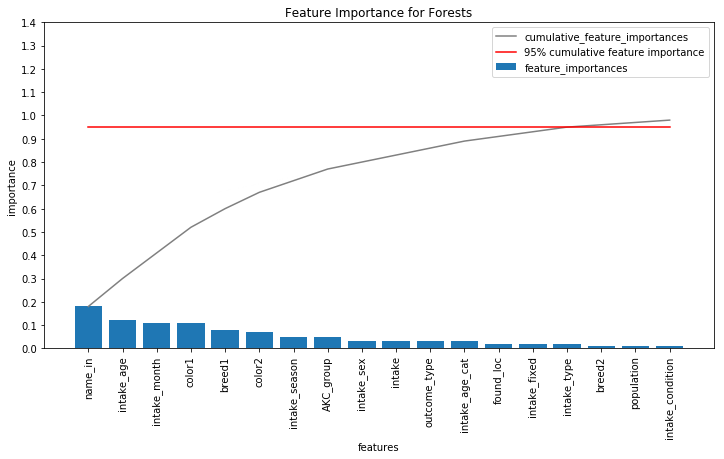

In [18]:
#set up the performance and importance dataframes
feat_imp_time = pd.DataFrame(index=data_shelter_time.columns.values)
f1_scores_time = pd.DataFrame(index=['f1'])

#for default tuned features we will just build a pipeline with the classifier and pass 0 to params
#set up pipeline
steps = [('Forests', RandomForestClassifier())]

pipeline_RF = Pipeline(steps)

#set up grid search cross validation parameters and other params needed to generate the classifier
params_RF = 0
adopted_labels=['less than 7 days','8 to 21 days','22 to 50 days','51+ days']



#run the classifier
RF_time_default, f1_adopted, sorted_feat_imp = rand_search_cv(pipeline = pipeline_RF, X=X_time, 
                                                            target=y_time, params=params_RF, class_labels=adopted_labels, 
                                                            split_test_size=.3, cv_folds=3, model_name='Forests',
                                                             prediction='shelter')

#store f1 and importance values in their respective dataframes
f1_scores_time.loc['f1','Default RF'] = f1_adopted

for index in feat_imp_time.index.values:
    feat_imp_time.loc[index,'Default RF'] = sorted_feat_imp.loc[index,'importance']

### Tuned RF for time to adoption
* The same parameters will be tuned as before for adopted predictions.

The best param values are value is {'Forests__n_estimators': 501, 'Forests__min_samples_split': 17, 'Forests__min_samples_leaf': 1, 'Forests__max_features': 'auto', 'Forests__criterion': 'entropy', 'Forests__bootstrap': False}, with an accuracy of 0.6604997527416586.

                  precision    recall  f1-score   support

less than 7 days       0.68      0.96      0.79      9314
    8 to 21 days       0.42      0.16      0.23      3130
   22 to 50 days       0.50      0.08      0.14      1226
        51+ days       0.63      0.16      0.25      1064

     avg / total       0.61      0.66      0.58     14734


The f1 score is : 0.5802345748624337


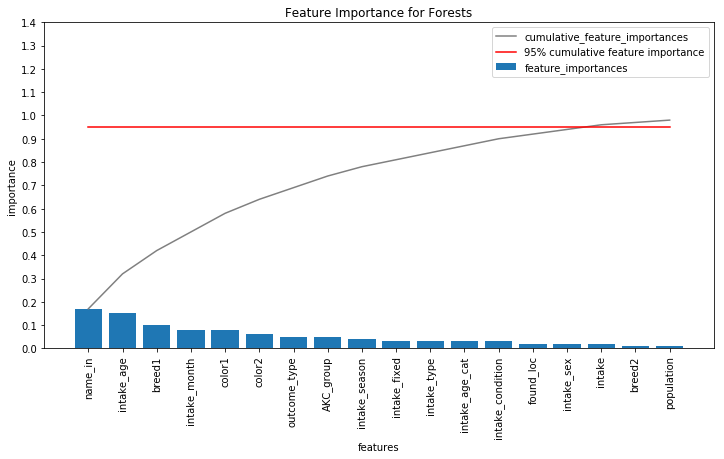

In [19]:
#for default we will just build a pipeline with the classifier and pass 0 to params
#set up pipeline
steps = [('Forests', RandomForestClassifier())]

pipeline_RF = Pipeline(steps)

#set up grid search cross validation parameters and other params needed to generate the classifier
params_RF = {"Forests__max_features": ['auto','log2'],
             "Forests__n_estimators": range(1, 5001, 100),
             "Forests__criterion": ['gini','entropy'],
             "Forests__min_samples_split": range(2,20),
             "Forests__min_samples_leaf": range(1,20),
             "Forests__bootstrap": [True, False]}

adopted_labels=['less than 7 days','8 to 21 days','22 to 50 days','51+ days']




RF_time_tuned, f1_adopted, sorted_feat_imp = rand_search_cv(pipeline = pipeline_RF, X=X_time, 
                                                            target=y_time, params=params_RF, class_labels=adopted_labels, 
                                                            split_test_size=.3, rand_iters=100, cv_folds=3,
                                                            model_name='Forests', prediction='shelter')

#store f1 and importance values in their respective dataframes
f1_scores_time.loc['f1','Tuned Hyper Parameters RF'] = f1_adopted

for index in feat_imp_time.index.values:
    feat_imp_time.loc[index,'Tuned Hyper Parameters RF'] = sorted_feat_imp.loc[index,'importance']

## AdaBoost for Time to Adoption Predictions
* The same procedure will be used as in the adopted predictions.

### Default AdaBoost

                  precision    recall  f1-score   support

less than 7 days       0.65      0.98      0.78      9314
    8 to 21 days       0.38      0.06      0.11      3130
   22 to 50 days       0.12      0.00      0.00      1226
        51+ days       0.67      0.12      0.20      1064

     avg / total       0.55      0.64      0.53     14734


The f1 score is : 0.531195674347815


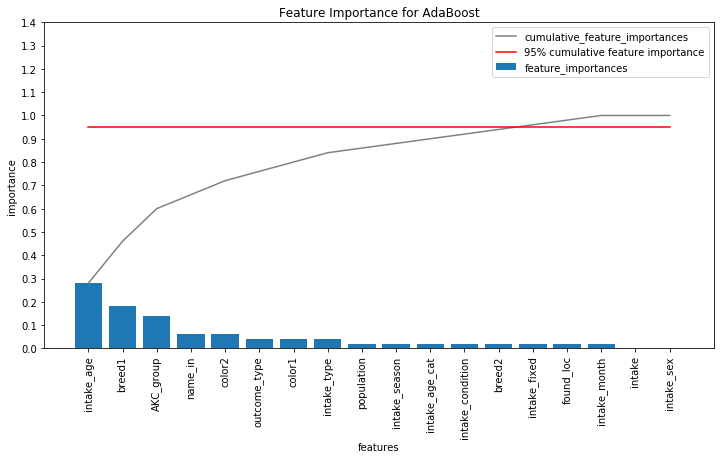

In [20]:
#for default reduced features we will just build a pipeline with the classifier and pass 0 to params
#set up pipeline
steps = [('AdaBoost', AdaBoostClassifier())]

pipeline_Ada = Pipeline(steps)

#set up grid search cross validation parameters and other params needed to generate the classifier
params_Ada = 0
adopted_labels=['less than 7 days','8 to 21 days','22 to 50 days','51+ days']



#run the classifier
Ada_time_default, f1_adopted, sorted_feat_imp = rand_search_cv(pipeline = pipeline_Ada, X=X_time, 
                                                            target=y_time, params=params_Ada, class_labels=adopted_labels,
                                                            split_test_size=.3, cv_folds=5, model_name='AdaBoost',
                                                              prediction='shelter')

#store f1 and importance values in their respective dataframes
f1_scores_time.loc['f1','Default Ada'] = f1_adopted

for index in feat_imp_time.index.values:
    feat_imp_time.loc[index,'Default Ada'] = sorted_feat_imp.loc[index,'importance']

### Tuned AdaBoost
* The same parameters will be tuned that were tuned for adopted predictions.

The best param values are value is {'AdaBoost__n_estimators': 1001, 'AdaBoost__learning_rate': 0.72208090183854634, 'AdaBoost__algorithm': 'SAMME'}, with an accuracy of 0.6484277278412892.

                  precision    recall  f1-score   support

less than 7 days       0.65      0.98      0.78      9314
    8 to 21 days       0.35      0.04      0.08      3130
   22 to 50 days       0.40      0.01      0.02      1226
        51+ days       0.72      0.11      0.19      1064

     avg / total       0.57      0.64      0.53     14734


The f1 score is : 0.5250783647909865


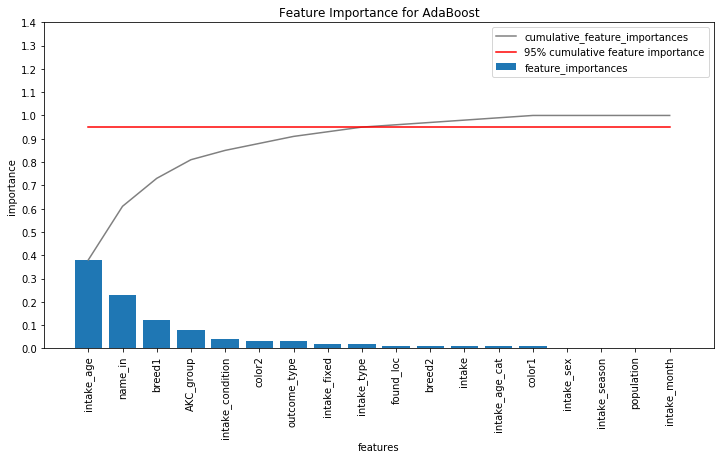

In [21]:
#set up pipeline
steps = [('AdaBoost', AdaBoostClassifier())]

pipeline_Ada = Pipeline(steps)

#set up grid search cross validation parameters and other params needed to generate the classifier
params_Ada = {'AdaBoost__n_estimators': range(1, 5001, 100),
              'AdaBoost__learning_rate': np.logspace(-1,4,100),
              'AdaBoost__algorithm':['SAMME','SAMME.R']}

adopted_labels=['less than 7 days','8 to 21 days','22 to 50 days','51+ days']



#run the classifier
Ada_time_tuned, f1_adopted, sorted_feat_imp = rand_search_cv(pipeline = pipeline_Ada, X=X_time, 
                                                            target=y_time, params=params_Ada, class_labels=adopted_labels,
                                                            split_test_size=.3, cv_folds=3, model_name='AdaBoost', 
                                                            rand_iters=100, prediction='shelter')

#store f1 and importance values in their respective dataframes
f1_scores_time.loc['f1','Tuned Ada'] = f1_adopted

for index in feat_imp_time.index.values:
    feat_imp_time.loc[index,'Tuned Ada'] = sorted_feat_imp.loc[index,'importance']

***

# Performance Summary
* Importance of the feature varied from model to model.  It also varied between the two predictions.
    * The top four important features on deciding outcome type for all models remained constant.
        * Name
        * Primary Color
        * Intake Age
        * Primary Breed
    * The rest changed depending on the model as shown in the bar plot below.  These mostly repeat our discoveries made in the statistical analysis portion where age, breed, and color were shown to be significant differentiators in adoptability.
    
    * For time to adoption predictions, there are only a few features that stand out as being important in determining the time to adoption.
        * Name
        * Intake Age
        * Primary Breed
    * More importance is place on these features when compared to the outcome_type prediction models.  Less importance is placed on the remaining features when compared to the outcome_type prediction models.
    
    
    * This reiterates what we found in the EDA and statistical analysis as well that the main deterimining factors in a dog's adoptableness and time to adoption are mainly the Age and the Breed.  Sex as shown in the statistical analysis and EDA is not important and so on.
    
    
* Now to move on to the performance of the models.  None of the models for either prediction did particularly amazing.  Outcome type predictions with a top f1 score of 0.74 (Tuned Hyper parameters RF).  The highest f1 score achieved by the shelter time prediction models was 0.59 (Default RF), which is barely better than random guessing.
    * However, looking into the data closer, every model seems to suffer from selection bias.  The largest group in each prediction performs much better than the other smaller groups.  As mentioned before, these groups represent what the shelter takes in and are the most meaningful for their data.  


* The correlation heat map below shows a few interesting insights.
    * First, most of the intake features are completely uncorrelated.
    * The outcome types and shelter times are not correlated either.
    * Breed population (top5 or not), name, and color seem to be the features most strongly correlated to the shelter_time.
        * They seem to be negatively correlated to the shelter time, suggesting that the larger the feature, the shorter the shelter time.  This means for name that the more popular a name is, the quicker the dog gets adopted.  However, this could be mostly due to the fact that there are more dogs with this name that went through the shelter and is subject to selection bias.
    * Name and intake condition are the only ones that seem to be correlated with outcome type.
        * They seem to be positively correlated.  This means that the higher the feature the higher the outcome type, which in this case increases from Adoption to Death.  For intake condition, this means that Normal condition intakes are more likely to be adopted than non normal intakes (pregnant, injured, feral, etc).  For name, this suggests that the more popular names upon intake are more likely to be other outcomes besides adoption.  From another viewpoint, this suggests that uniquely named dogs are more likely to be adopted.
    *  For the intake features, there are a few interesting correlations that describe trends in the intake demographic for the shelter.
        * Primary and secondary color are negatively correlated suggesting that less popular intake primary colors have secondary colors.
        * Name and age are negatively correlated suggesting that older dogs have less popular names.
        * Age and fixed status are negatively correlated suggesting that the older the dogs are the more likely that they will be fixed.
        * Age_cat and age are strongly correlated.  This is a sanity check and probably redundant encoded information.
        * Fixed status and intake number are negatively correlated suggesting that the dogs are fixed on the first visit to the shelter.  This is good for animal population control and making sure that every animal can be given a good home and not stuck in the wild and doomed to become overpopulated.
        * Population and primary breed are strongly negatively correlated.  This is another sanity check and redundant encoded features.
        * AKC grouping and primary breed are negatively correlated.  This suggests that most popular breeds for shelter intakes are in the Sporting, Hound, Herding, and Terrier AKC groups.
        * Month and season are negatively correlated which is redundant time of intake encoded information.
        * AKC grouping and population are positively correlated.  This suggests that the less popular breeds upon intake are in the Non-Sporting, Toy, Working, and Misc groups.
    


* Thoughts on future improvements:
    * More data and more features captured by the shelter.
    * Different groupings could be made to try and ease the selection bias.
        * However, this might alter the usefulness of the predictions with predicted classes that aren't so useful.
    * Use the rest of the shelter intake data regarding cats and other animals.
    * Use the features of the dogs currently in the shelter as a set of additional features.
    * Try different algorithms such as logistic regression, k nearest neighbors, support vector classification, etc
    * Further fine tuning with GridSearchCV could be done.
    * Try regression for the time to adoption.

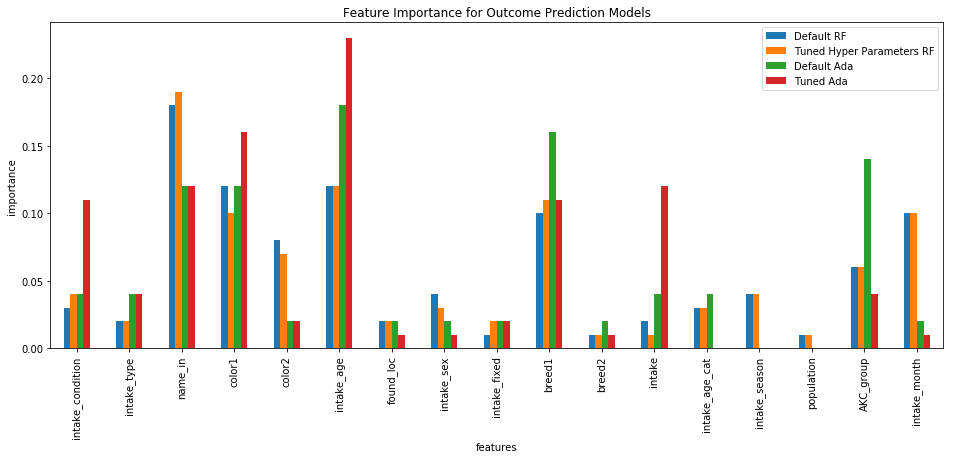

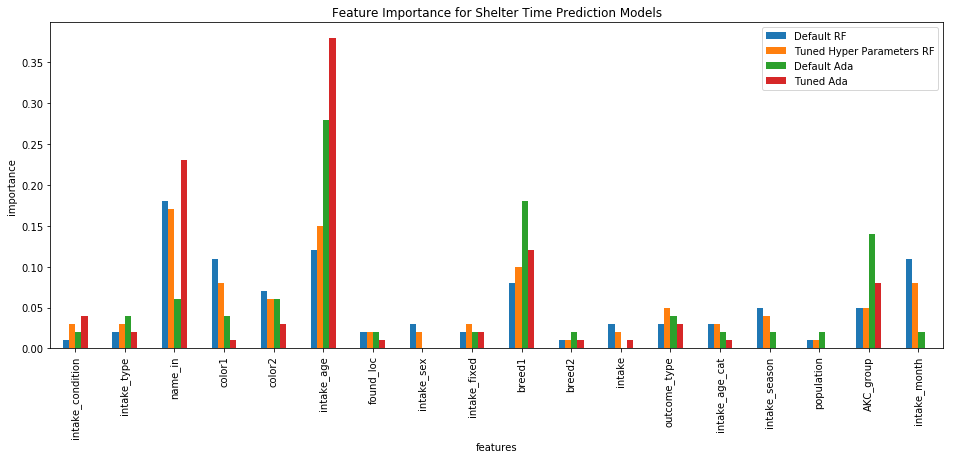

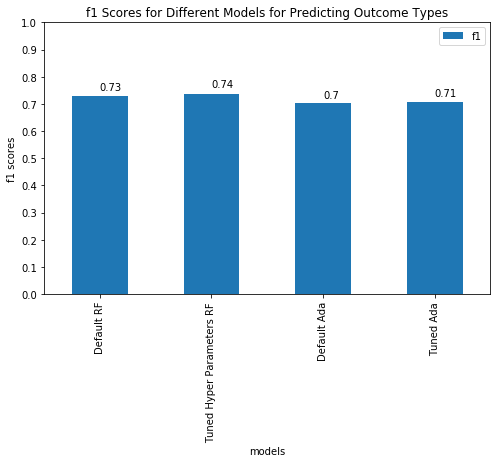

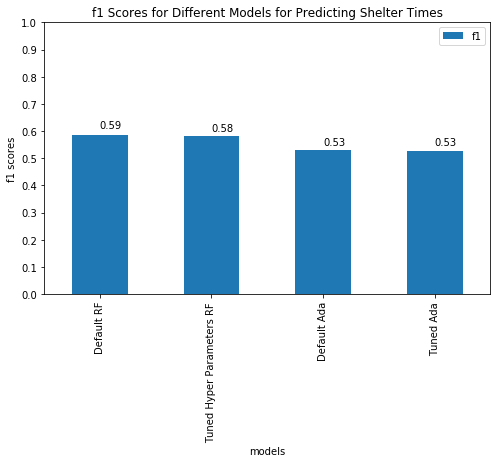

In [40]:
#feature importance graphs
feat_imp_outcome.plot(kind='bar', figsize=(16,6))
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature Importance for Outcome Prediction Models')
plt.show()

feat_imp_time.plot(kind='bar', figsize=(16,6))
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature Importance for Shelter Time Prediction Models')
plt.show()

#f1 score plots
f1_scores_outcome.transpose().plot(kind='bar', figsize=(8,5))
plt.xlabel('models')
plt.ylabel('f1 scores')
plt.yticks(np.arange(0,1.1,0.1))
for index,f1 in enumerate(f1_scores_outcome.loc['f1',:]):
    plt.annotate(str(np.round(f1,2)), xy = (index, np.round(f1,2)+.02))
plt.title('f1 Scores for Different Models for Predicting Outcome Types')
plt.show()

f1_scores_time.transpose().plot(kind='bar', figsize=(8,5))
plt.xlabel('models')
plt.ylabel('f1 scores')
plt.yticks(np.arange(0,1.1,0.1))
for index,f1 in enumerate(f1_scores_time.loc['f1',:]):
    plt.annotate(str(np.round(f1,2)), xy = (index, np.round(f1,2)+.02))
plt.title('f1 Scores for Different Models for Predicting Shelter Times')
plt.show()

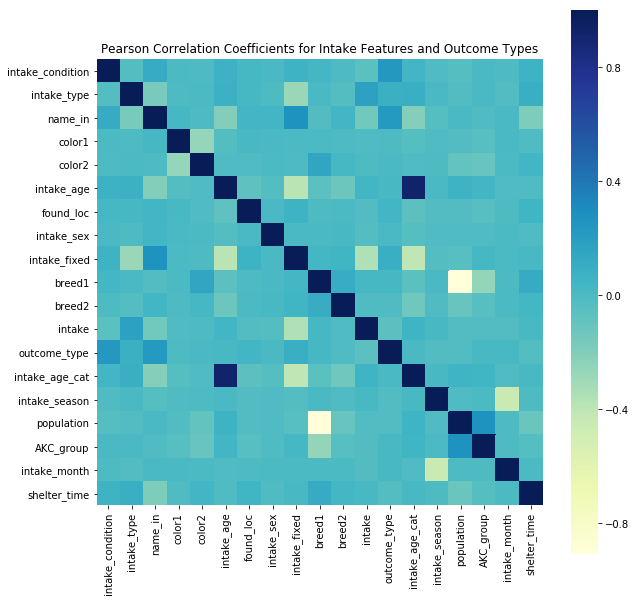

In [47]:
#look at the correlation heatmap of the intake features, outcome_type, and shelter_time
plt.figure(figsize=(10,10))
sns.heatmap(pd.concat([data_shelter_time, labels.shelter_time], axis=1).corr(),square=True,cmap='YlGnBu', annot=False)
plt.title('Pearson Correlation Coefficients for Intake Features and Outcome Types')
plt.show()